In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import scipy
from sklearn.metrics import roc_curve, roc_auc_score
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras import Input
from tensorflow.keras.optimizers import Adam, AdamW
tf.random.set_seed(2)

import pyhf

In [2]:
dataframe = pd.read_csv('dataframe.csv')

In [3]:
dataframe['train_weight'] = 1.
dataframe.loc[dataframe.query('label==1').index,'train_weight'] = (dataframe.loc[dataframe.query('label==1').index,'scaleweight']) / dataframe.loc[dataframe.query('label==1').index,'scaleweight'].sum()
dataframe.loc[dataframe.query('label==0').index,'train_weight'] = dataframe.loc[dataframe.query('label==0').index,'scaleweight'] / dataframe.loc[dataframe.query('label==0').index,'scaleweight'].sum()

sum_w_sig = dataframe.query('label==0')['train_weight'].sum()
sum_w_bkg = dataframe.query('label==1')['train_weight'].sum()
print(f'Sum of weights for training Signal {sum_w_sig:.3} and Background {sum_w_bkg:.3}')

Sum of weights for training Signal 1.0 and Background 1.0


In [4]:
train_features = ['etmiss', 'mtw', 'leadleptPt', 'leadleptEta',
       'leadleptE', 'leadleptPhi', 'Q_leadlep', 'leadleptID', 'n_TopLRjets',
       'leadTopLRjet_pt', 'leadTopLRjet_eta', 'leadTopLRjet_phi',
       'leadTopLRjet_m', 'leadTopLRjet_Tau32', 'n_jets', 'leadjet_pt',
       'leadjet_eta', 'n_bjets', 'leadbjet_pt', 'leadbjet_eta', 'ttbarMLR']

weights = ["scaleweight", "train_weight"]

In [5]:

x_train, x_val, y_train, y_val, w_train_full, w_val_full = train_test_split(dataframe[train_features].values, dataframe['label'].values, dataframe[weights].values, train_size = 1/3, random_state = 9)
x_val, x_test, y_val, y_test, w_val_full, w_test_full = train_test_split(x_val, y_val, w_val_full, test_size=1/2, random_state = 9)


scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)


In [6]:
def weight_separation(w):
    scaleweights = w[:, 0]
    train = w[:, 1]
    return scaleweights, train

w_train_scale, w_train = weight_separation(w_train_full)
w_val_scale, w_val = weight_separation(w_val_full)
w_test_scale, w_test = weight_separation(w_test_full)

In [7]:
# your answer
model = Sequential([Input(shape=(x_train.shape[1],))])

# Input and Hidden layers

model.add(Dense(80, activation='tanh'))
model.add(Dense(90, activation='tanh'))
model.add(Dense(90, activation='tanh'))
model.add(Dense(80, activation='tanh'))
model.add(Dense(75, activation='tanh'))



# Output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), weighted_metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 90)             │         8,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 75)             │         6,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,671 (119.81 KB)

 Trainable params: 30,671 (119.81 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(x_train, y_train, sample_weight=w_train, validation_data=(x_val, y_val, w_val), epochs=200, batch_size=1024, callbacks=[EarlyStopping(patience=2)])

Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4875 - loss: 5.7303e-06 - val_accuracy: 0.4829 - val_loss: 5.6335e-06
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4987 - loss: 5.6368e-06 - val_accuracy: 0.5021 - val_loss: 5.5445e-06
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5267 - loss: 5.5649e-06 - val_accuracy: 0.5173 - val_loss: 5.4859e-06
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5507 - loss: 5.5189e-06 - val_accuracy: 0.5349 - val_loss: 5.4459e-06
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5574 - loss: 5.4879e-06 - val_accuracy: 0.5488 - val_loss: 5.4173e-06
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5618 - loss: 5.4661e-06 - val_accuracy: 0.5561 - val_loss: 5.3964e-06
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5637 - loss: 5.4506e-06 - val_accuracy: 0.5602 - val_loss: 5.3811e-06
Epoch 8/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - ac

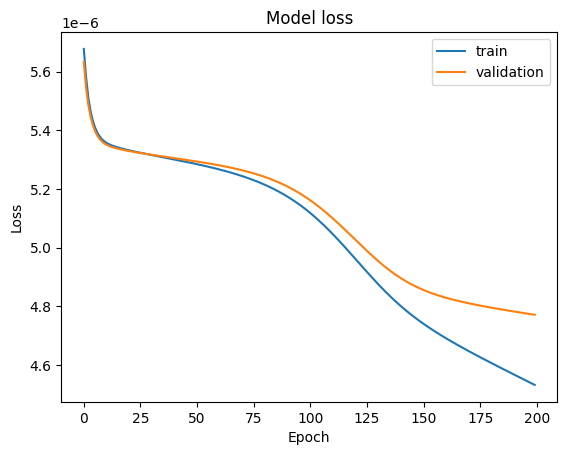

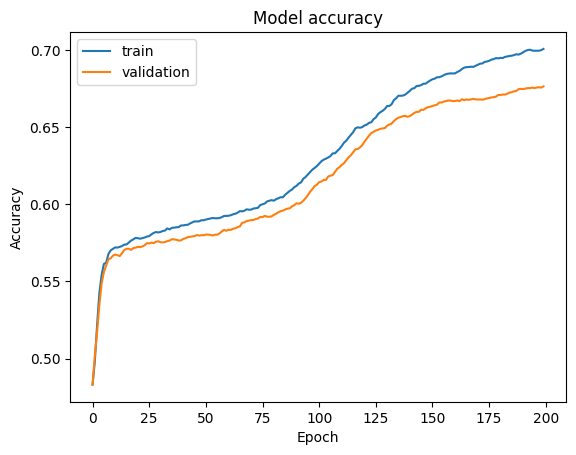

In [9]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

2626/2626 ━━━━━━━━━━━━━━━━━━━━ 1s 220us/step
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 1s 252us/step
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 1s 225us/step


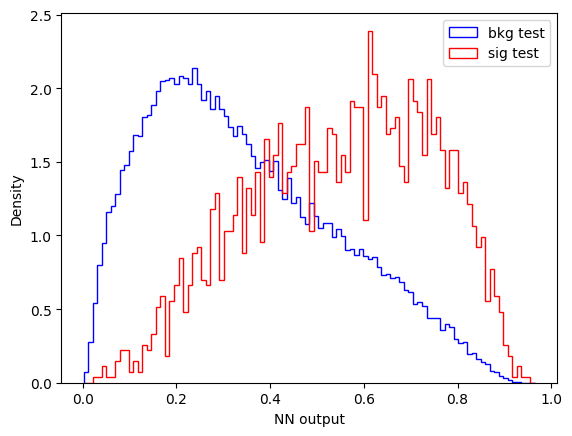

In [11]:
bin = plt.hist(y_test_pred[y_test==0], bins=100, density=True, histtype='step', color='blue', label='bkg test')
plt.hist(y_test_pred[y_test==1], bins=bin[1], density=True, histtype='step', color='red', label='sig test')

plt.xlabel('NN output')
plt.ylabel('Density')
plt.legend()

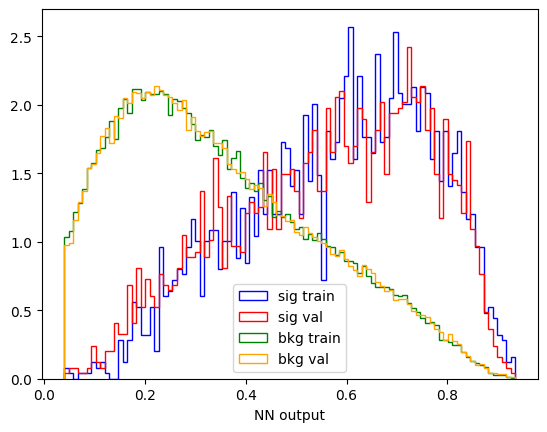

In [12]:
# your answer
bins = plt.hist(y_train_pred[y_train==1], bins=100, density=True, histtype='step', color='blue', label='sig train')
plt.hist(y_val_pred[y_val==1], bins=bins[1], density=True, histtype='step', color='red', label='sig val')
bins = plt.hist(y_train_pred[y_train==0], bins=bins[1], density=True, histtype='step', color='green', label='bkg train')
plt.hist(y_val_pred[y_val==0], bins=bins[1], density=True, histtype='step', color='orange', label='bkg val')

plt.xlabel('NN output')
plt.legend()
plt.show()


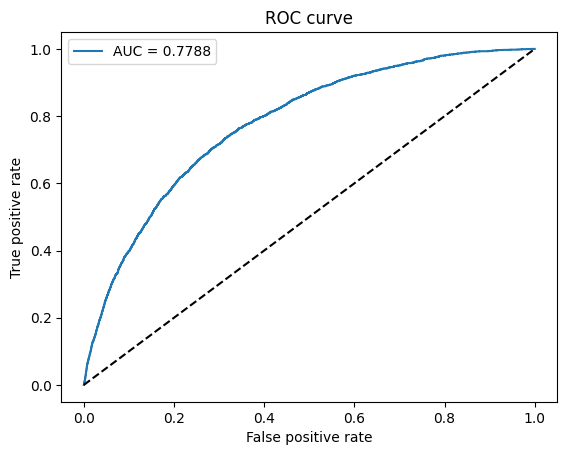

In [13]:
# RPC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
auc = roc_auc_score(y_val, y_val_pred)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

In [14]:
# join the y predictions and scaleweights into a dataframe with two columns
def join_y_w(y, w):
    df = pd.DataFrame({'y_pred': y, 'scaleweights': w})
    return df

df_train = join_y_w(y_train_pred[:, 0], w_train_scale[:])
df_val = join_y_w(y_val_pred[:, 0], w_val_scale[:])
df_test = join_y_w(y_test_pred[:, 0], w_test_scale[:]*3)

In [15]:
df_test

,y_pred,scaleweights
0,0.420725,0.294725
1,0.535601,0.223335
2,0.388531,0.009947
3,0.166165,0.010237
4,0.157741,0.311842
...,...,...
84027,0.170792,0.325935
84028,0.072519,0.017029
84029,0.060556,0.162489
84030,0.569349,0.007456


In [16]:
data = pd.read_csv('Output_ZPrimeBoostedAnalysis/data.csv', delimiter= " ")
data

,etmiss,mtw,leadleptPt,leadleptEta,leadleptE,leadleptPhi,Q_leadlep,leadleptID,n_TopLRjets,leadTopLRjet_pt,...,n_bjets,leadbjet_pt,leadbjet_eta,ttbarMLR,largeRjet_pt_total,largeRjet_eta_total,largeRjet_phi_total,largeRjet_m_total,largeRjet_tau32_total,weight
0,140.8590,112.6010,173.3020,-0.719597,220.1410,-0.629445,1,11,1,303.808,...,2,74.2067,1.155760,0.000,303.808,0.716499,2.340630,105.440,0.701667,1
1,101.1240,12.9607,84.2450,0.521832,95.9780,1.694020,1,13,1,319.519,...,1,229.1180,-0.005455,0.000,319.519,-0.207688,-1.050650,124.417,0.658574,1
2,93.8502,145.9590,69.5917,-0.571767,81.2804,2.401100,1,11,1,379.502,...,1,354.8290,0.387903,0.000,379.502,0.429905,-0.032258,101.729,0.705147,1
3,79.1584,78.5076,39.4455,0.320825,41.4930,1.189650,-1,11,1,364.358,...,2,111.3740,-1.131620,0.000,673.232,-0.882717,2.047210,211.584,1.222030,1
4,49.9677,119.0770,78.1793,-1.261530,149.0890,-0.060379,1,11,1,381.640,...,4,327.3410,-0.637407,836.840,749.172,-1.939400,-0.584009,245.185,1.182330,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13983,51.2650,36.3069,32.4356,-1.826030,103.3120,2.875370,1,11,1,313.153,...,1,63.3124,-2.219060,0.000,313.153,-1.469270,-0.309966,149.170,0.428863,1
13984,177.2230,98.1917,226.8500,0.625051,272.6260,2.951550,-1,13,1,403.237,...,1,79.7143,0.725713,858.712,403.237,-0.551284,-0.521822,163.453,0.696539,1
13985,379.7260,76.7778,38.0448,0.559037,44.1463,-2.853520,1,13,1,618.111,...,2,120.5620,2.143520,0.000,883.045,1.610580,-3.028970,283.641,1.011700,1
13986,76.5990,32.0798,68.3700,-0.439462,75.0790,-0.758893,1,11,1,336.483,...,1,173.8460,1.078890,0.000,336.483,1.348570,1.986230,103.251,0.382302,1


In [17]:
x_data = scaler.transform(data[train_features].values)
w_data = data["weight"].values

In [18]:
y_data_pred = model.predict(x_data)

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


In [19]:
df_data = join_y_w(y_data_pred[:, 0], w_data[:])

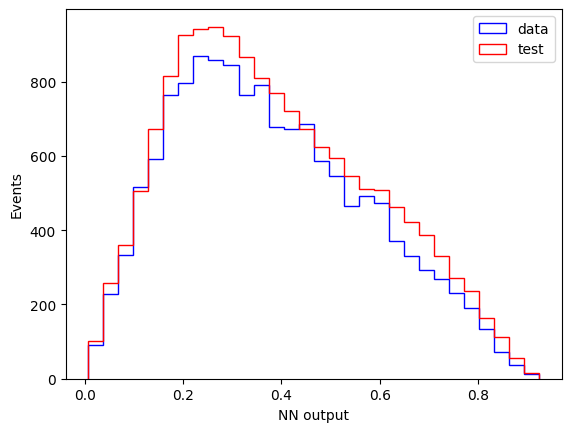

In [20]:
bins = plt.hist(df_data['y_pred'], bins=30, histtype='step', color='blue', label='data', weights=df_data['scaleweights'])
plt.hist(df_test['y_pred'], bins=bins[1], histtype='step', color='red', label='test', weights=df_test['scaleweights'])
plt.xlabel('NN output')
plt.ylabel('Events')
plt.legend()

In [21]:
N, bins = np.histogram(df_data['y_pred'], bins=50, weights=df_data['scaleweights'])

B = np.histogram(df_test['y_pred'][y_test==0], bins=bins, weights=df_test['scaleweights'][y_test==0])[0]
S = np.histogram(df_test['y_pred'][y_test==1], bins=bins, weights=df_test['scaleweights'][y_test==1])[0]


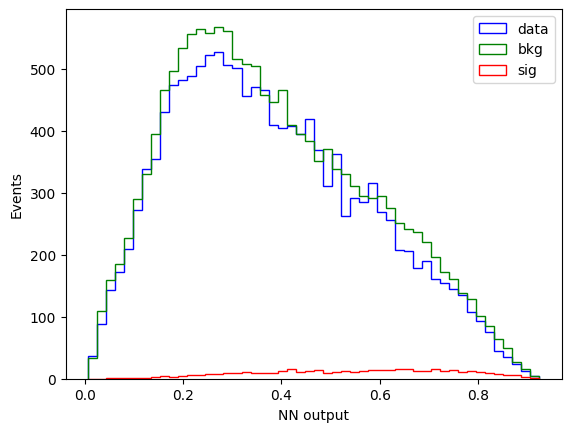

In [22]:
# Plot N, S, B
plt.hist(bins[:-1], bins, weights=N, histtype='step', color='blue', label='data')
plt.hist(bins[:-1], bins, weights=B, histtype='step', color='green', label='bkg')
plt.hist(bins[:-1], bins, weights=S, histtype='step', color='red', label='sig')
plt.xlabel('NN output')
plt.ylabel('Events')
plt.legend()
plt.show()

In [23]:
model_spec = {'channels': [{'name': 'singlechannel',
              'samples': [
              {'name': 'signal','data': S.tolist(),
               'modifiers': [{'data': None, 'name': 'mu', 'type': 'normfactor'}]},
              {'name': 'bkg1','data': B.tolist(),
               'modifiers': []},
              ]
              }],
              "observations": [{ "name": "singlechannel", "data": N.tolist() }],
              "measurements": [{ "name": "Measurement", "config": {"poi": "mu", "parameters": []}}],
              "version": "1.0.0",
}

workspace = pyhf.Workspace(model_spec)
model = workspace.model()

print("## Model")
print(f"  channels: {model.config.channels}")
print(f"     nbins: {model.config.channel_nbins}")
print(f"   samples: {model.config.samples}")
print(f" modifiers: {model.config.modifiers}")
print(f"parameters: {model.config.parameters}")
print(f"par. order: {model.config.par_order}")

print("\n## Model parameters")
print(f'   default: {model.config.suggested_init()}')
print(f'    bounds: {model.config.suggested_bounds()}')

data = N.tolist() + model.config.auxdata

test_stat = "qtilde"
test_poi = 1.

# Vary mu values
poi_values = np.linspace(0.01, 5, 500)
obs_limit, exp_limits = pyhf.infer.intervals.upper_limits.upper_limit(data, model, poi_values, level=0.05)
print(f"\nObserved μ upper limit (obs): {obs_limit:.3f}, Expected μ upper limit {exp_limits[2]:.3f}")

## Model
  channels: ['singlechannel']
     nbins: {'singlechannel': 50}
   samples: ['bkg1', 'signal']
 modifiers: [('mu', 'normfactor')]
parameters: ['mu']
par. order: ['mu']

## Model parameters
   default: [1.0]
    bounds: [(0, 10)]

Observed μ upper limit (obs): 0.077, Expected μ upper limit 0.417


In [24]:
data = N.tolist() + model.config.auxdata

test_stat = "qtilde"
test_poi = 1.

# Vary mu values
poi_values = np.linspace(0.01, 5, 500)
obs_limit, exp_limits = pyhf.infer.intervals.upper_limits.upper_limit(data, model, poi_values, level=0.05)
print(f"\nObserved μ upper limit (obs): {obs_limit:.3f}, Expected μ upper limit {exp_limits[2]:.3f}")


Observed μ upper limit (obs): 0.077, Expected μ upper limit 0.417
